## Pronostia

In [1]:
import pandas as pd
import pickle as pk
import numpy as np


In [4]:
pd.set_option('display.max_rows', 500)

def stat(X):
    X = X.copy()
    X = X[['method', 'feature faker', 'score']].drop_duplicates()
    X.loc[X.method == 'Saliency', 'score'] = X[X.method == 'Saliency'].score.max()
    X.loc[X.method == 'LRP', 'score'] = X[X.method == 'LRP'].score.max()
    X.loc[X.method == 'GRADCAM', 'score'] = X[X.method == 'GRADCAM'].score.max()

    return X.drop_duplicates()

def resume_results(base_dir, exclude=[]):
    I = pd.DataFrame(data=pk.load(open(base_dir + 'identity.pk', 'rb')))
    SEP = pd.DataFrame(data=pk.load(open(base_dir + 'separability.pk', 'rb')))
    STA = pd.DataFrame(data=pk.load(open(base_dir + 'stability.pk', 'rb')))
    SEL = pd.DataFrame(data=pk.load(open(base_dir + 'selectivity.pk', 'rb')))
    CS = pd.DataFrame(data=pk.load(open(base_dir + 'cs.pk', 'rb')))
    ACU = pd.DataFrame(data=pk.load(open(base_dir + 'acumen.pk', 'rb')))

    I = stat(I)
    I = I.rename(columns={'score': 'Identity'})
    S = stat(SEP)
    S = S.rename(columns={'score': 'Separability'})
    STA = stat(STA)
    STA = STA.rename(columns={'score': 'Stability'})
    SEL = stat(SEL)
    SEL = SEL.rename(columns={'score': 'Selectivity'})
    ACU = stat(ACU)
    ACU = ACU.rename(columns={'score': 'Acumen'})
    
    CS = CS.copy()
    CS['score_aux'] = CS.score
    CS['score'] = CS.score_aux.map(lambda x: x['coherence'])
    COH = stat(CS)
    COH = COH.rename(columns={'score': 'Coherence'})
    
    CS['score'] = CS.score_aux.map(lambda x: x['completeness'])
    COM = stat(CS)
    COM = COM.rename(columns={'score': 'Completeness'})

    CS['score'] = CS.score_aux.map(lambda x: x['congruency'])
    CON = stat(CS)
    CON = CON.rename(columns={'score': 'Congruency'})
    
    COH = COH[['method', 'feature faker', 'Coherence']]
    COM = COM[['method', 'feature faker', 'Completeness']]
    CON = CON[['method', 'feature faker', 'Congruency']]
    
    R = I.merge(S, on=['method', 'feature faker'])
    R = R.merge(STA, on=['method', 'feature faker'])
    R = R.merge(SEL, on=['method', 'feature faker'])
    R = R.merge(COH, on=['method', 'feature faker'])
    R = R.merge(COM, on=['method', 'feature faker'])
    R = R.merge(CON, on=['method', 'feature faker'])
    R = R.merge(ACU, on=['method', 'feature faker'])
    
    R = R.rename(columns={'feature faker': 'Permutation'})
    R = R.rename(columns={'method': 'Method'})
    
    GC = read_GC(base_dir + 'gradcam1_1.pk', exclude=exclude)
    del GC['Time_dimension']
    del GC['Feature_dimension']
    del GC['Layer']
    GC = GC[GC.Total == GC.Total.max()]
    GC['Method'] = 'GradCAM'
    GC.index = [5]
   
    R = R.round(decimals=3)
    R.loc[(R.Permutation=='one') & (R.Method == 'Kernel SHAP'), 'Identity'] = 1
    R.loc[(R.Permutation=='zero') & (R.Method == 'Kernel SHAP'), 'Identity'] = 1
    R.loc[(R.Permutation=='one') & (R.Method == 'Lime'), 'Identity'] = 1
    R.loc[(R.Permutation=='zero') & (R.Method == 'Lime'), 'Identity'] = 1


    R = R[R.Method != 'GRADCAM']
    R = pd.concat((R, GC), axis=0)
    R = R.sort_index()
    
    cols= ['Identity', 'Separability', 'Stability', 'Selectivity', 'Coherence', 'Completeness', 'Congruency', 'Acumen']
    for c in exclude:
        del R[c]
        del GC[c]
    
    cols = [c for c in cols if c not in exclude]

    
    R['Total'] = R[cols].mean(axis=1)

    
    R = R.round(3)
    
    perm_map = {
        'normal_noise': 'n.noise',
        'uniform_noise': 'u.noise',
        np.nan: ''
    }
    
    R['Permutation'] = R.Permutation.map(lambda x: x if x not in perm_map else perm_map[x] )
    
    R['Method'] = R.Method.map(lambda x: 'SHAP' if x == 'Kernel SHAP' else x)
    
    return R

def read_GC(path, exclude=[]):
    GC = pd.DataFrame(data=pk.load(open(path, 'rb')))
    GC = GC.groupby(['method', 'time_dimension', 'feature_dimension', 'layer']).score.mean().reset_index()
    GC = GC.pivot(index=['time_dimension', 'feature_dimension', 'layer'], columns=['method'], values=['score']).reset_index()
    proxy_cols = [c[1] for c in GC.columns[3:]]
    
    GC.columns = ['time_dimension', 'feature_dimension', 'layer'] + proxy_cols
    GC['Total'] = GC[proxy_cols].mean(axis=1)
   
    layers = list(np.unique(GC.layer.values))
    layers = [(l, int(l.split('_')[1])) for l in layers]
    layers = sorted(layers, key=lambda x: x[1])
    layers = [l for l,_ in layers]

    GC['layer'] = GC.layer.map(lambda x: layers.index(x))
    GC.columns = [c.capitalize() for c in GC.columns]
    
    
    
    return GC

base_dir_pronostia = '../data/models/pronostia/results/'
R = resume_results(base_dir_pronostia)
R

,Method,Permutation,Identity,Separability,Stability,Selectivity,Coherence,Completeness,Congruency,Acumen,Total
0,SHAP,mean,0.0,1.000,-0.009,0.533,0.054,0.989,0.105,0.495,0.396
1,SHAP,n.noise,0.0,1.000,0.020,0.532,0.053,0.991,0.103,0.485,0.398
2,SHAP,u.noise,0.0,1.000,0.078,0.521,0.032,0.994,0.084,0.487,0.400
3,SHAP,zero,1.0,1.000,0.011,0.529,0.012,0.997,0.045,0.519,0.514
4,SHAP,one,1.0,1.000,-0.015,0.528,0.093,0.997,0.128,0.402,0.517
5,GradCAM,,1.0,0.976,0.368,0.531,0.141,0.980,0.134,0.206,0.542
6,LRP,,0.0,1.000,0.042,0.536,0.158,0.970,0.133,0.502,0.418
7,Saliency,,1.0,1.000,-0.122,0.544,0.155,0.975,0.131,0.180,0.483
8,Lime,mean,0.0,1.000,0.038,0.538,0.040,0.986,0.081,0.553,0.405
9,Lime,n.noise,0.0,1.000,0.034,0.538,0.042,0.985,0.083,0.537,0.402


In [459]:
base_dir_ncmapss = '../data/models/ncmapss/results/'
R = resume_results(base_dir_ncmapss)
R

,Method,Permutation,Identity,Separability,Stability,Selectivity,Coherence,Completeness,Congruency,Acumen,Total
0,Saliency,,1.000,0.999,0.055,0.434,0.174,0.972,0.163,0.516,0.539
1,LRP,,1.000,1.000,-0.037,0.599,0.180,0.967,0.165,0.495,0.546
2,Lime,mean,0.004,1.000,0.130,0.569,0.173,0.962,0.161,0.685,0.461
3,Lime,n.noise,0.008,1.000,0.131,0.572,0.173,0.960,0.162,0.677,0.460
4,Lime,u.noise,0.012,1.000,0.109,0.560,0.166,0.960,0.162,0.577,0.443
5,Lime,zero,1.000,1.000,0.554,0.835,0.160,1.017,0.146,0.753,0.683
5,GradCAM,,1.000,1.000,0.653,0.702,0.196,0.948,0.170,0.435,0.638
6,Lime,one,1.000,1.000,0.349,0.728,0.184,0.969,0.166,0.069,0.558
8,SHAP,mean,0.000,1.000,0.033,0.582,0.120,0.973,0.152,0.505,0.421
9,SHAP,n.noise,0.000,1.000,0.037,0.581,0.116,0.968,0.150,0.501,0.419


In [427]:
base_dir_batteries = '../data/models/fast_charge/results/'
R = resume_results(base_dir_batteries)
R
#print(R.to_latex(index=False))

,Method,Permutation,Identity,Separability,Stability,Selectivity,Coherence,Completeness,Congruency,Acumen,Total
0,SHAP,mean,0.000,1.000,0.119,0.584,0.097,0.903,0.121,0.418,0.405
1,SHAP,n.noise,0.000,1.000,0.120,0.588,0.100,0.900,0.122,0.383,0.402
2,SHAP,u.noise,0.000,1.000,0.180,0.616,0.107,0.893,0.121,0.303,0.403
3,SHAP,zero,1.000,1.000,0.153,0.597,0.093,0.908,0.130,0.536,0.552
4,SHAP,one,1.000,1.000,0.176,0.526,0.077,0.923,0.113,0.269,0.510
5,LRP,,0.441,1.000,0.007,0.659,0.073,0.936,0.076,0.492,0.460
5,GradCAM,,1.000,1.000,0.259,0.666,0.063,1.050,0.080,0.322,0.555
6,Saliency,,1.000,0.990,0.163,0.517,0.170,0.831,0.157,0.452,0.535
7,Lime,mean,0.023,1.000,0.456,0.595,0.087,0.913,0.116,0.501,0.461
8,Lime,n.noise,0.023,1.000,0.447,0.598,0.087,0.914,0.115,0.529,0.464


#### GRAD-CAM

In [442]:
GC = read_GC(base_dir_pronostia + 'gradcam1_1.pk')

In [443]:
GC.Total.max()

0.5418875626486829

In [444]:
GC[GC.Total == GC.Total.max()]

,Time_dimension,Feature_dimension,Layer,Acumen,Coherence,Completeness,Congruency,Identity,Selectivity,Separability,Stability,Total
440,0.5,0.5,2,0.205739,0.141297,0.979667,0.133837,1.0,0.531036,0.975915,0.367609,0.541888


#### Charts

In [429]:
GCB = read_GC(base_dir_batteries + 'gradcam1_1.pk')
GCP = read_GC(base_dir_pronostia + 'gradcam1_1.pk')
GCN= read_GC(base_dir_ncmapss + 'gradcam1_1.pk')
GC = pd.concat((GCB, GCP, GCN), axis=0)
GC = GCN

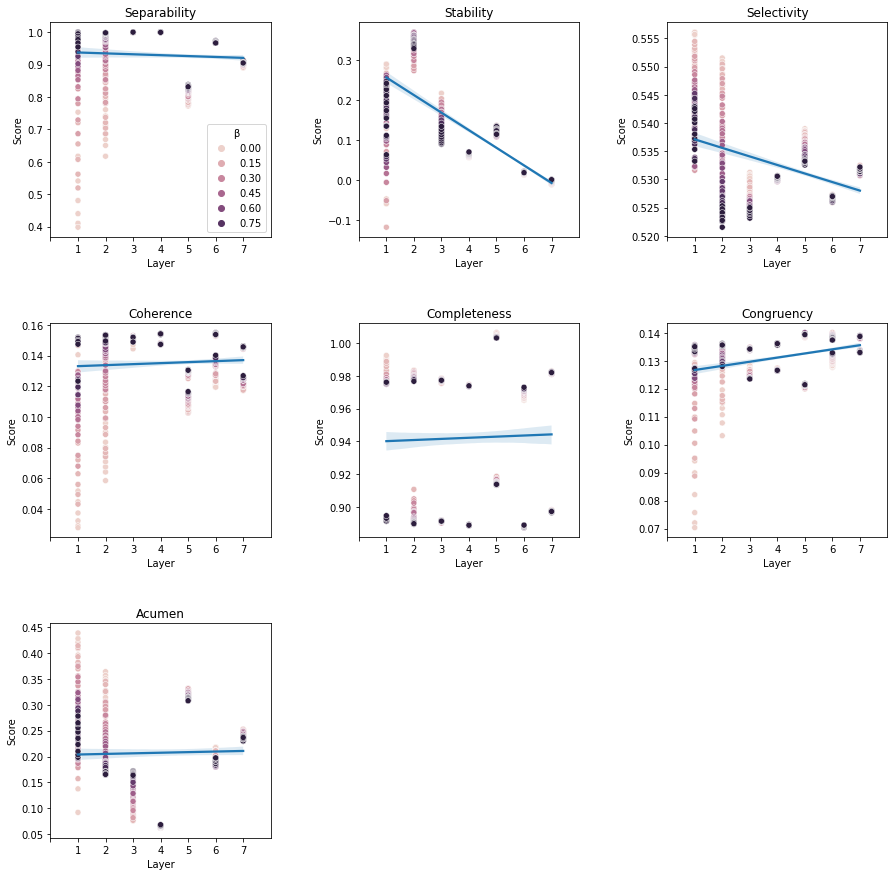

In [430]:
from matplotlib import pyplot as plt
import seaborn as sns


def layer_depth_charts(GC, output_name='chart.svg'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i,y in enumerate(['Separability', 'Stability', 'Selectivity', 'Coherence', 
                       'Completeness', 'Congruency', 'Acumen']):
        ax = fig.add_subplot(3, 3, i+1)

        GC = GC.copy()
        d = GC.loc[(GC.Layer >= 1), ['Time_dimension', 'Layer', y]]
        d.rename({y: 'Score', 'Time_dimension': 'β'}, inplace=True, axis=1)
        sns.regplot(data=d, x='Layer', y='Score',  scatter=False, ax=ax)
        sns.scatterplot(data=d, x='Layer', y='Score', hue='β', ax=ax)

        if i > 0:
            plt.legend([],[], frameon=False)
        ax.set_title(y)
        ax.set_xlim([0, GC.Layer.max()+1])
        ax.set_xticks(range(GC.Layer.max()+1), [None] + list(range(1, GC.Layer.max()+1)))


        plt.savefig(output_name)
        
layer_depth_charts(GCP, output_name='ld_pronostia.svg')

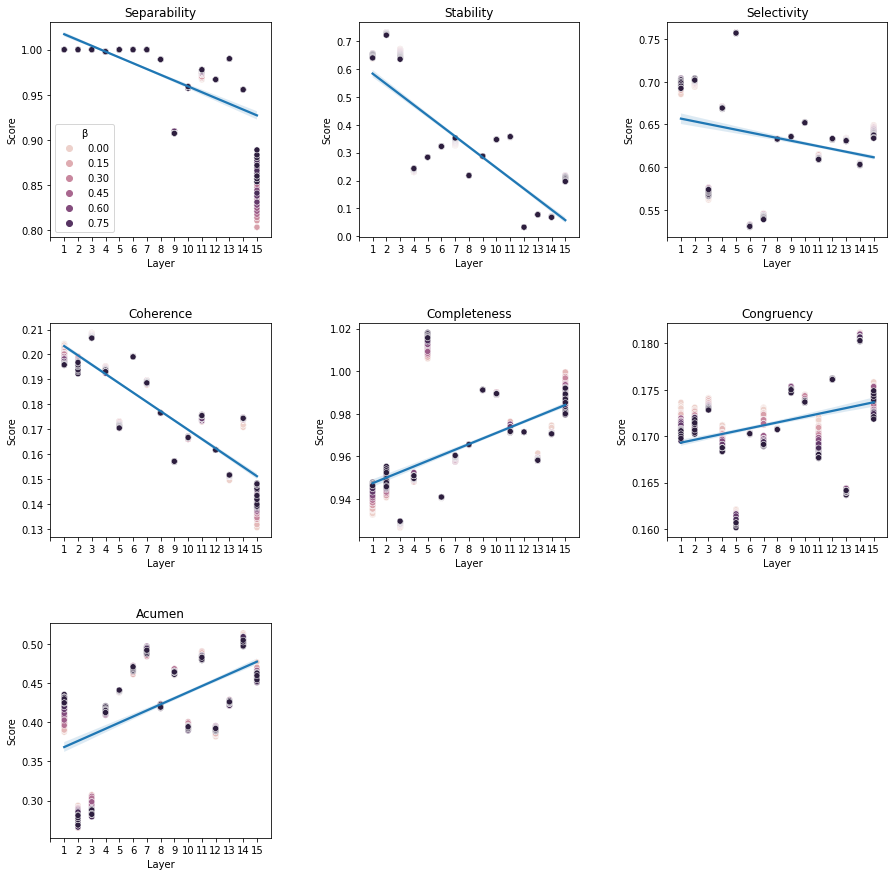

In [431]:
layer_depth_charts(GCN, output_name='ld_ncmapss.svg')

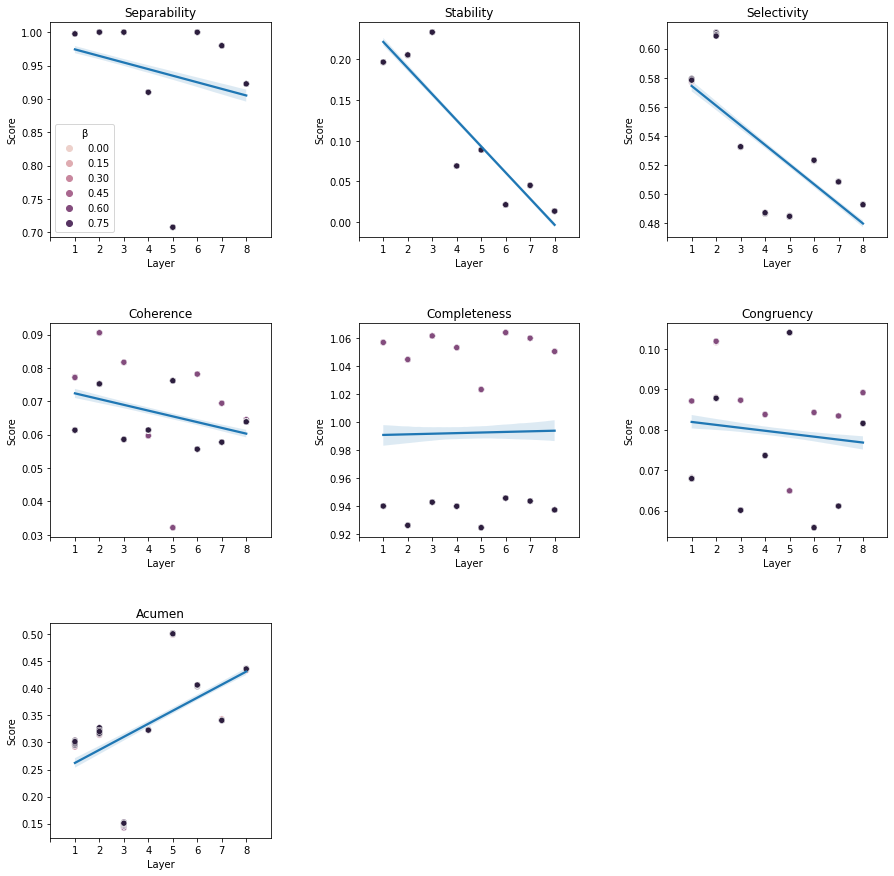

In [432]:
layer_depth_charts(GCB, output_name='ld_batteries.svg')

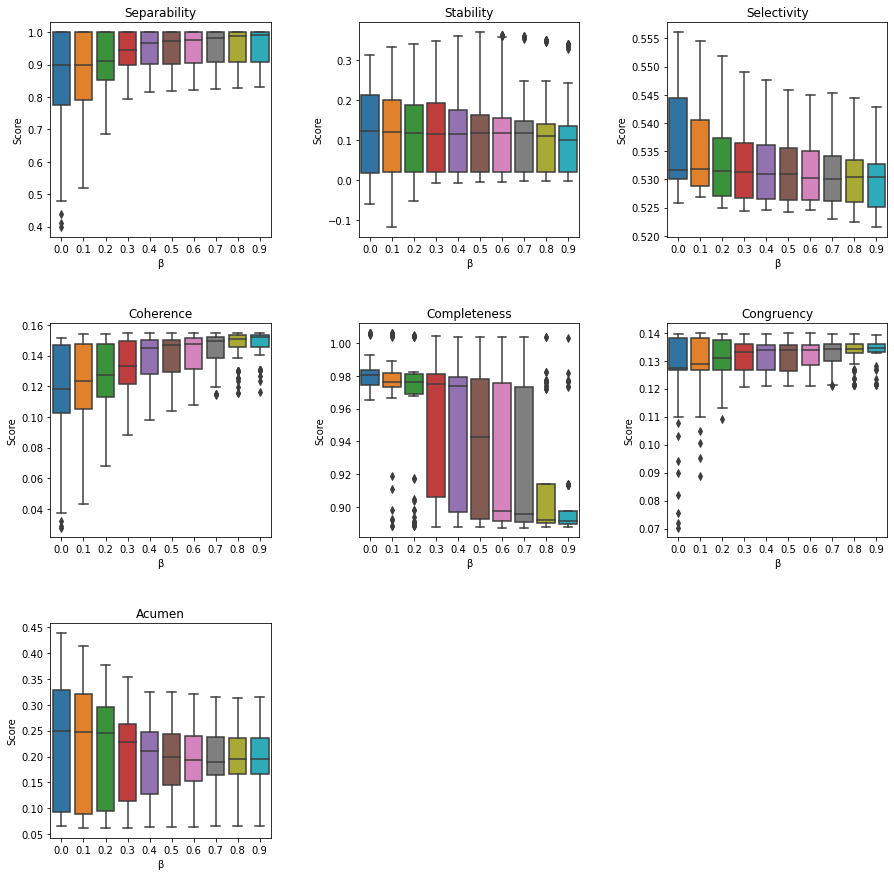

In [452]:
def time_dimension_charts(GC, output_name='chart.svg'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i,y in enumerate(['Separability', 'Stability', 'Selectivity', 'Coherence', 
                       'Completeness', 'Congruency', 'Acumen']):
        ax = fig.add_subplot(3, 3, i+1)

        GC = GC.copy()
        d = GC.loc[(GC.Layer >= 1), ['Time_dimension', 'Layer', y]]
        d.rename({y: 'Score', 'Time_dimension': 'β'}, inplace=True, axis=1)
        #sns.regplot(data=d, x='β', y='Score',  scatter=False, ax=ax)
        #sns.scatterplot(data=d, x='β', y='Score', ax=ax)
        sns.boxplot(data=d, x='β', y='Score', ax=ax)

        if i > 0:
            plt.legend([],[], frameon=False)
        ax.set_title(y)
        #ax.set_xlim([-0.1, 1.1])
        #ax.set_xticks(range(GC.Layer.max()+1), [None] + list(range(1, GC.Layer.max()+1)))


        plt.savefig(output_name)

time_dimension_charts(GC, output_name='time_dimension.svg')

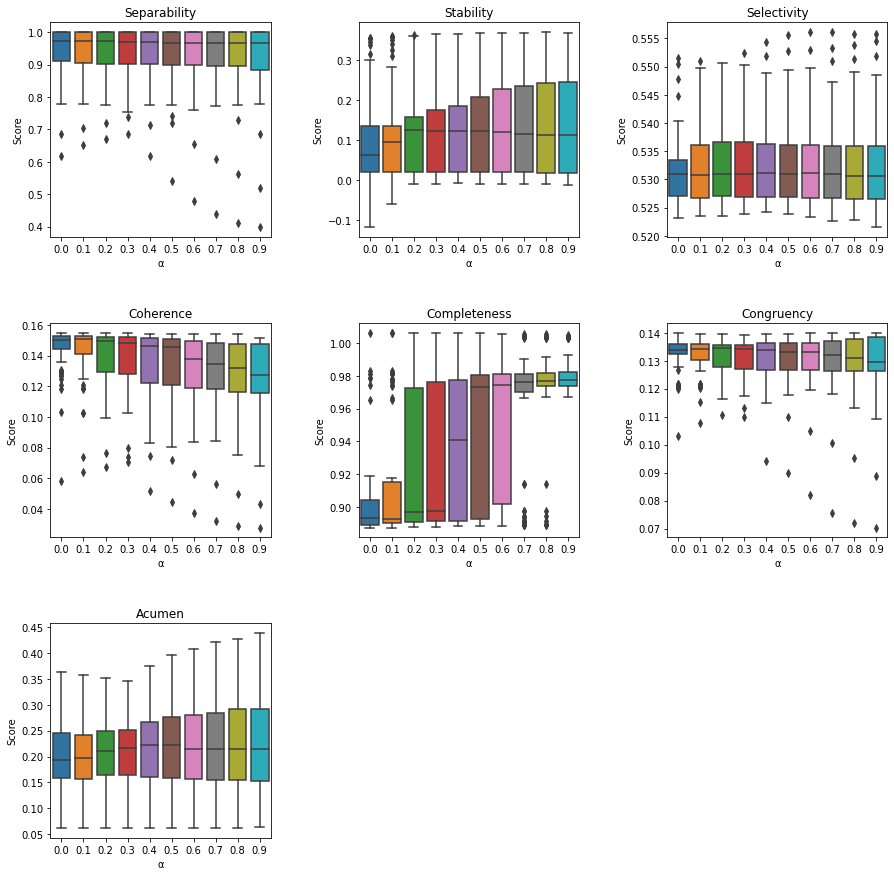

In [455]:
def feature_dimension_charts(GC, output_name='chart.svg'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i,y in enumerate(['Separability', 'Stability', 'Selectivity', 'Coherence', 
                       'Completeness', 'Congruency', 'Acumen']):
        ax = fig.add_subplot(3, 3, i+1)

        GC = GC.copy()
        d = GC.loc[(GC.Layer >= 1), ['Feature_dimension', 'Layer', y]]
        d.rename({y: 'Score', 'Feature_dimension': 'α'}, inplace=True, axis=1)
        #sns.regplot(data=d, x='β', y='Score',  scatter=False, ax=ax)
        #sns.scatterplot(data=d, x='β', y='Score', ax=ax)
        sns.boxplot(data=d, x='α', y='Score', ax=ax)

        if i > 0:
            plt.legend([],[], frameon=False)
        ax.set_title(y)
        #ax.set_xlim([-0.1, 1.1])
        #ax.set_xticks(range(GC.Layer.max()+1), [None] + list(range(1, GC.Layer.max()+1)))


        plt.savefig(output_name)

feature_dimension_charts(GC, output_name='feature_dimension.svg')